# **Research papers Meta Data Analysis**

## **Data Loading**

The dataset used is officially outsourced from Kaggle which is containing ArXiv website's total research papers.
Arxiv is a collaboratively funded, community-supported resource founded by Paul Ginsparg in 1991 and maintained and operated by Cornell University.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sumnth","key":"f01ed2e400f7316260a23805ccbd1aab"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
 98% 1.26G/1.28G [00:06<00:00, 223MB/s]
100% 1.28G/1.28G [00:06<00:00, 205MB/s]


In [ ]:
!unzip arxiv.zip

Archive:  arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


## **Importing Libraries**

In [ ]:
import json
import dask.bag as db
import json
import re
import pandas as pd
import numpy as np

#for plotting
import altair as alt
import random
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go

#for web scrapping
import requests
from bs4 import BeautifulSoup

In [ ]:
#for word analysing
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

## **Using Dask**

 The dataset which available in kaggle is in form of json format can be accessed by using dask and json libraries

In [ ]:
loaded_data = db.read_text('/content/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [ ]:
a= print("The dataset has {} entires.".format(loaded_data.count().compute()))
a

The dataset has 2477303 entires.


In [ ]:
#Example from Dataset
print("Data Structure:")
loaded_data.take(1)

Data Structure:


({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

In [ ]:
extract_latest_version=lambda x:x['versions'][-1]["created"]

In [ ]:
data_after_2015=loaded_data.filter(lambda x:int(extract_latest_version(x).split(" ")[3])>=2015)

In [ ]:
print("Number of Papers Published Since 2015 ",data_after_2015.count().compute())

Number of Papers Published Since 2015  1510204


In [ ]:
data_after_2019=loaded_data.filter(lambda x:int(extract_latest_version(x).split(" ")[3])>=2019)

In [ ]:
print("Number of Papers Published Since 2019 ",data_after_2019.count().compute())

Number of Papers Published Since 2019  1043498


In [ ]:
df = data_after_2019.to_dataframe()

In [ ]:
df_result = df.compute()

## Making CS_Arxiv Dataset

Taking the required data from the available dataset which is in json and converting it into dataframe to analyse

In [ ]:
complete_dataset = "/content/arxiv-metadata-oai-snapshot.json"
partial_dataset = "./arxiv.json"
extract_latest_version = lambda x: x['versions'][-1]["created"]
filter_year = lambda x: int(extract_latest_version(x).split(" ")[3]) >= 2019
with open(complete_dataset, 'r') as f_in, open(partial_dataset, 'w') as f_out:
    for line in f_in:
        entry = json.loads(line)
        if filter_year(entry):
            json.dump(entry, f_out)
            f_out.write('\n')


In [ ]:
pd.set_option("display.max_colwidth", None)
arxiv_df = pd.read_json(partial_dataset, lines=True)

In [ ]:
complete_dataset = "/content/arxiv-metadata-oai-snapshot.json"
partial_dataset = "./arxiv_cs.json"

pattern = r"(^|\s)cs\."

with open(complete_dataset, 'r') as f_in, open(partial_dataset, 'w') as f_out:
    for line in f_in:
        entry = json.loads(line)
        if re.search(pattern, entry["categories"]):
            json.dump(entry, f_out)
            f_out.write('\n')

In [ ]:
df= db.read_text('/content/arxiv_cs.json').map(json.loads)

In [ ]:
print("The dataset has {} entires.".format(df.count().compute()))

The dataset has 623757 entires.


In [ ]:
pd.set_option("display.max_colwidth", None)
cs_arxiv_df = pd.read_json(partial_dataset, lines=True)

In [ ]:
print(len(cs_arxiv_df))

623757


## EDA

In [ ]:
cs_arxiv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621547 entries, 0 to 621546
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              621547 non-null  object
 1   submitter       621320 non-null  object
 2   authors         621547 non-null  object
 3   title           621547 non-null  object
 4   comments        374033 non-null  object
 5   journal-ref     82675 non-null   object
 6   doi             110740 non-null  object
 7   report-no       9838 non-null    object
 8   categories      621547 non-null  object
 9   license         610164 non-null  object
 10  abstract        621547 non-null  object
 11  versions        621547 non-null  object
 12  update_date     621547 non-null  object
 13  authors_parsed  621547 non-null  object
dtypes: object(14)
memory usage: 66.4+ MB


In [ ]:
def convert_to_tuple(item):
    if isinstance(item, list):
        return tuple(convert_to_tuple(x) for x in item)
    elif isinstance(item, dict):
        return tuple((k, convert_to_tuple(v)) for k, v in item.items())
    else:
        return item

converted_tuples = cs_arxiv_df.applymap(convert_to_tuple)
unique_tuples = converted_tuples.nunique()

In [ ]:
print("number of unique values: ")
unique_tuples

number of unique values: 


id                621547
submitter         205784
authors           551535
title             621019
comments          245095
journal-ref        77179
doi               110465
report-no           9375
categories         38515
license                9
abstract          621212
versions          620866
update_date         4755
authors_parsed    537292
dtype: int64

### **Missing Values Calculation**

In [ ]:
cs_arxiv_df.isnull().sum()

id                     0
submitter            227
authors                0
title                  0
comments          247514
journal-ref       538872
doi               510807
report-no         611709
categories             0
license            11383
abstract               0
versions               0
update_date            0
authors_parsed         0
dtype: int64

**Null Pecentage in Each Column**

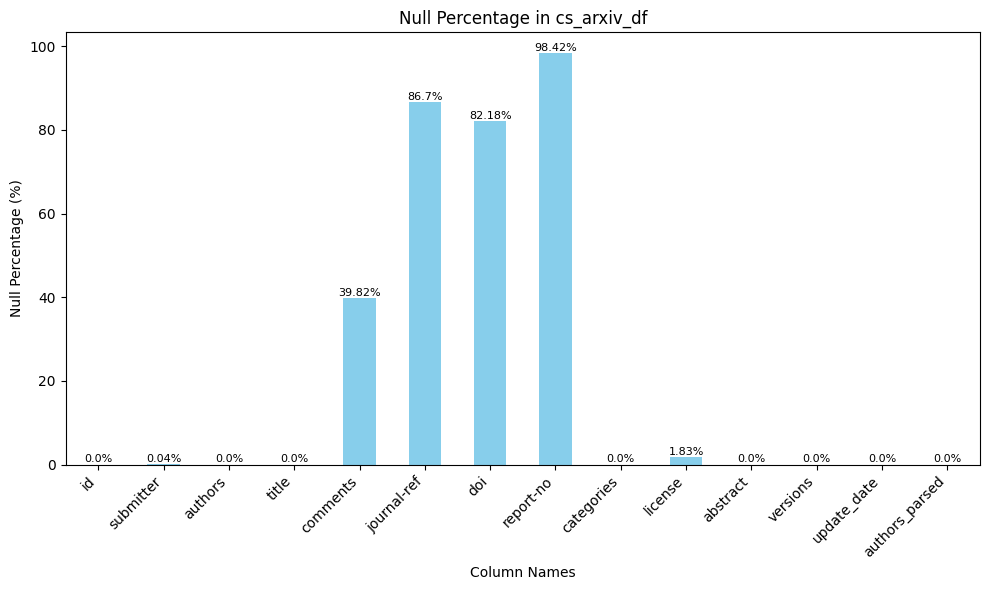

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

null_percentage = ((cs_arxiv_df.isnull().sum() / len(cs_arxiv_df)) * 100).round(2)
plt.figure(figsize=(10, 6))
bars = null_percentage.plot(kind='bar', color='skyblue')

for bar, label in zip(bars.containers[0], null_percentage.round(2)):
    x, y = bar.get_xy()
    width = bar.get_width()
    height = bar.get_height()
    plt.text(x + width / 2, height + 0.05, f"{label}%", ha='center', va='bottom', fontsize=8)

plt.xlabel('Column Names')
plt.ylabel('Null Percentage (%)')
plt.title('Null Percentage in cs_arxiv_df')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


### **Data Reduction**

In [ ]:
data = cs_arxiv_df.drop(['comments', 'journal-ref', 'doi','report-no'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621547 entries, 0 to 621546
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              621547 non-null  object
 1   submitter       621320 non-null  object
 2   authors         621547 non-null  object
 3   title           621547 non-null  object
 4   categories      621547 non-null  object
 5   license         610164 non-null  object
 6   abstract        621547 non-null  object
 7   versions        621547 non-null  object
 8   update_date     621547 non-null  object
 9   authors_parsed  621547 non-null  object
dtypes: object(10)
memory usage: 47.4+ MB


### **Feature Engineering**

In [ ]:
def format_text(text):
    words = text.split()
    if len(words) > 1:
        return ', '.join(words)
    else:
        return text

data['categories'] = data['categories'].apply(format_text)


data.head(4)

,id,submitter,authors,title,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,"math.CO, cs.CG",http://arxiv.org/licenses/nonexclusive-distrib/1.0/,"We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use\nit obtain a characterization of the family of $(k,\ell)$-sparse graphs and\nalgorithmic solutions to a family of problems concerning tree decompositions of\ngraphs. Special instances of sparse graphs appear in rigidity theory and have\nreceived increased attention in recent years. In particular, our colored\npebbles generalize and strengthen the previous results of Lee and Streinu and\ngive a new proof of the Tutte-Nash-Williams characterization of arboricity. We\nalso present a new decomposition that certifies sparsity based on the\n$(k,\ell)$-pebble game with colors. Our work also exposes connections between\npebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and\nWestermann and Hendrickson.\n","[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 02:26:18 GMT'}, {'version': 'v2', 'created': 'Sat, 13 Dec 2008 17:26:00 GMT'}]",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
1,0704.0046,Denes Petz,"I. Csiszar, F. Hiai and D. Petz",A limit relation for entropy and channel capacity per unit cost,"quant-ph, cs.IT, math.IT",None,"In a quantum mechanical model, Diosi, Feldmann and Kosloff arrived at a\nconjecture stating that the limit of the entropy of certain mixtures is the\nrelative entropy as system size goes to infinity. The conjecture is proven in\nthis paper for density matrices. The first proof is analytic and uses the\nquantum law of large numbers. The second one clarifies the relation to channel\ncapacity per unit cost for classical-quantum channels. Both proofs lead to\ngeneralization of the conjecture.\n","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 16:37:36 GMT'}]",2009-11-13,"[[Csiszar, I., ], [Hiai, F., ], [Petz, D., ]]"
2,0704.0047,Igor Grabec,T. Kosel and I. Grabec,Intelligent location of simultaneously active acoustic emission sources:\n Part I,"cs.NE, cs.AI",None,"The intelligent acoustic emission locator is described in Part I, while Part\nII discusses blind source separation, time delay estimation and location of two\nsimultaneously active continuous acoustic emission sources.\n The location of acoustic emission on complicated aircraft frame structures is\na difficult problem of non-destructive testing. This article describes an\nintelligent acoustic emission source locator. The intelligent locator comprises\na sensor antenna and a general regression neural network, which solves the\nlocation problem based on learning from examples. Locator performance was\ntested on different test specimens. Tests have shown that the accuracy of\nlocation depends on sound velocity and attenuation in the specimen, the\ndimensions of the tested area, and the properties of stored data. The location\naccuracy achieved by the intelligent locator is comparable to that obtained by\nthe conventional triangulation method, while the applicability of the\nintelligent locator is more general since analysis of sonic ray paths is\navoided. This is a promising method for non-destructive testing of aircraft\nframe structures by the acoustic emission method.\n","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 13:06:50 GMT'}]",2009-09-29,"[[Kosel, T., ], [Grabec, I., ]]"
3,0704.0050,Igor Grabec,T. Kosel and I. Grabec,Intelligent location of simultaneously active acoustic emission sources:\n Part II,"cs.NE, cs.AI",None,"Part I describes an intelligent acoustic emission locator, while Part II\ndiscusses blind source separation, time delay estimation and location of two\ncontinuous acoustic emission sources.\n Acoustic emission (AE) analysis is used for characterization and location of\ndeveloping defects in materials. AE sources often generate a mixture of various\nstatistically indepen

In [ ]:
data['authors'] = data['authors'].str.replace(' and ', ',')

In [ ]:
def preprocess(abstract):
    abstract = abstract.str.replace("$(k,\ell)$-", " ")
    abstract = abstract.str.replace('\n', ' ')
    abstract = abstract.str.replace('$n$', ' ')
    abstract = abstract.str.replace('$m$', ' ')
    return abstract

data['abstract'] = preprocess(data['abstract'])
data['title'] = preprocess(data['title'])

In [ ]:
data.head(4)

,id,submitter,authors,title,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0002,Louis Theran,"Ileana Streinu,Louis Theran",Sparsity-certifying Graph Decompositions,"[math.CO, cs.CG]",http://arxiv.org/licenses/nonexclusive-distrib/1.0/,"We describe a new algorithm, the pebble game with colors, and use it obtain a characterization of the family of sparse graphs and algorithmic solutions to a family of problems concerning tree decompositions of graphs. Special instances of sparse graphs appear in rigidity theory and have received increased attention in recent years. In particular, our colored pebbles generalize and strengthen the previous results of Lee and Streinu and give a new proof of the Tutte-Nash-Williams characterization of arboricity. We also present a new decomposition that certifies sparsity based on the pebble game with colors. Our work also exposes connections between pebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and Westermann and Hendrickson.","[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 02:26:18 GMT'}, {'version': 'v2', 'created': 'Sat, 13 Dec 2008 17:26:00 GMT'}]",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
1,0704.0046,Denes Petz,"I. Csiszar, F. Hiai,D. Petz",A limit relation for entropy and channel capacity per unit cost,"[quant-ph, cs.IT, math.IT]",None,"In a quantum mechanical model, Diosi, Feldmann and Kosloff arrived at a conjecture stating that the limit of the entropy of certain mixtures is the relative entropy as system size goes to infinity. The conjecture is proven in this paper for density matrices. The first proof is analytic and uses the quantum law of large numbers. The second one clarifies the relation to channel capacity per unit cost for classical-quantum channels. Both proofs lead to generalization of the conjecture.","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 16:37:36 GMT'}]",2009-11-13,"[[Csiszar, I., ], [Hiai, F., ], [Petz, D., ]]"
2,0704.0047,Igor Grabec,"T. Kosel,I. Grabec",Intelligent location of simultaneously active acoustic emission sources: Part I,"[cs.NE, cs.AI]",None,"The intelligent acoustic emission locator is described in Part I, while Part II discusses blind source separation, time delay estimation and location of two simultaneously active continuous acoustic emission sources. The location of acoustic emission on complicated aircraft frame structures is a difficult problem of non-destructive testing. This article describes an intelligent acoustic emission source locator. The intelligent locator comprises a sensor antenna and a general regression neural network, which solves the location problem based on learning from examples. Locator performance was tested on different test specimens. Tests have shown that the accuracy of location depends on sound velocity and attenuation in the specimen, the dimensions of the tested area, and the properties of stored data. The location accuracy achieved by the intelligent locator is comparable to that obtained by the conventional triangulation method, while the applicability of the intelligent locator is more general since analysis of sonic ray paths is avoided. This is a promising method for non-destructive testing of aircraft frame structures by the acoustic emission method.","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 13:06:50 GMT'}]",2009-09-29,"[[Kosel, T., ], [Grabec, I., ]]"
3,0704.0050,Igor Grabec,"T. Kosel,I. Grabec",Intelligent location of simultaneously active acoustic emission sources: Part II,"[cs.NE, cs.AI]",None,"Part I describes an intelligent acoustic emission locator, while Part II discusses blind source separation, time delay estimation and location of two continuous acoustic emission sources. Acoustic emission (AE) analysis is used for characterization and location of developing defects in materials. AE sources often generate a mixture of various statistically independent signals. A difficult problem of AE analysis is separation and characterization

In [ ]:
def string_to_list(category_string):
    return [cat.strip() for cat in category_string.split(',')]
data['categories'] = data['categories'].apply(string_to_list)

data.head(2)


,id,submitter,authors,title,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0002,Louis Theran,"Ileana Streinu,Louis Theran",Sparsity-certifying Graph Decompositions,"[math.CO, cs.CG]",http://arxiv.org/licenses/nonexclusive-distrib/1.0/,"We describe a new algorithm, the pebble game with colors, and use it obtain a characterization of the family of sparse graphs and algorithmic solutions to a family of problems concerning tree decompositions of graphs. Special instances of sparse graphs appear in rigidity theory and have received increased attention in recent years. In particular, our colored pebbles generalize and strengthen the previous results of Lee and Streinu and give a new proof of the Tutte-Nash-Williams characterization of arboricity. We also present a new decomposition that certifies sparsity based on the pebble game with colors. Our work also exposes connections between pebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and Westermann and Hendrickson.","[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 02:26:18 GMT'}, {'version': 'v2', 'created': 'Sat, 13 Dec 2008 17:26:00 GMT'}]",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
1,0704.0046,Denes Petz,"I. Csiszar, F. Hiai,D. Petz",A limit relation for entropy and channel capacity per unit cost,"[quant-ph, cs.IT, math.IT]",None,"In a quantum mechanical model, Diosi, Feldmann and Kosloff arrived at a conjecture stating that the limit of the entropy of certain mixtures is the relative entropy as system size goes to infinity. The conjecture is proven in this paper for density matrices. The first proof is analytic and uses the quantum law of large numbers. The second one clarifies the relation to channel capacity per unit cost for classical-quantum channels. Both proofs lead to generalization of the conjecture.","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 16:37:36 GMT'}]",2009-11-13,"[[Csiszar, I., ], [Hiai, F., ], [Petz, D., ]]"


In [ ]:
arxiv_data = data[['categories','title','abstract']]
arxiv_data.head(2)

,categories,title,abstract
0,"[math.CO, cs.CG]",Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the pebble game with colors, and use it obtain a characterization of the family of sparse graphs and algorithmic solutions to a family of problems concerning tree decompositions of graphs. Special instances of sparse graphs appear in rigidity theory and have received increased attention in recent years. In particular, our colored pebbles generalize and strengthen the previous results of Lee and Streinu and give a new proof of the Tutte-Nash-Williams characterization of arboricity. We also present a new decomposition that certifies sparsity based on the pebble game with colors. Our work also exposes connections between pebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and Westermann and Hendrickson."
1,"[quant-ph, cs.IT, math.IT]",A limit relation for entropy and channel capacity per unit cost,"In a quantum mechanical model, Diosi, Feldmann and Kosloff arrived at a conjecture stating that the limit of the entropy of certain mixtures is the relative entropy as system size goes to infinity. The conjecture is proven in this paper for density matrices. The first proof is analytic and uses the quantum law of large numbers. The second one clarifies the relation to channel capacity per unit cost for classical-quantum channels. Both proofs lead to generalization of the conjecture."


## **Publication Trends**:


### **Number of Collected  Published Research Papers Over Time (1986-2024)**

In [ ]:
get_latest_version = lambda x: x['versions'][-1]['created']
dates = (loaded_data
         .map(get_latest_version)
         .frequencies(sort = True))
(dates.topk(10, key=1)
      .compute())

[('Wed, 27 Jun 2012 19:59:59 GMT', 103),
 ('Tue, 14 Feb 2012 16:41:17 GMT', 82),
 ('Thu, 15 Mar 2012 11:17:56 GMT', 78),
 ('Sun, 1 Dec 2002 00:00:00 GMT', 35),
 ('Thu, 1 Jul 1999 00:00:00 GMT', 22),
 ('Wed, 1 Apr 1992 00:00:00 GMT', 22),
 ('Wed, 8 Apr 1992 22:58:34 GMT', 18),
 ('Thu, 9 Feb 1995 00:00:00 GMT', 18),
 ('Wed, 1 Jan 1992 00:00:00 GMT', 17),
 ('Fri, 9 Jul 1993 00:00:00 GMT', 17)]

In [ ]:
date = pd.DataFrame(dates, columns=['submission_datetime', 'submissions'])

date['submission_datetime'] = pd.to_datetime(date['submission_datetime'], format='%a, %d %b %Y %H:%M:%S %Z')

date['year'] = date['submission_datetime'].dt.year

yearly_submissions = date.groupby('year')['submissions'].sum().reset_index()

yearly_submissions.columns = ['year', 'total_submissions']

yearly_submissions.head(4)

,year,total_submissions
0,1986,1
1,1988,1
2,1989,5
3,1990,24


In [ ]:
chart = alt.Chart(yearly_submissions).mark_area(
    line={'color': '#54a34a'},
    color=alt.Gradient(
        gradient='linear',
        stops=[
            alt.GradientStop(color='white', offset=0),
            alt.GradientStop(color='#54a34a', offset=1)
        ],
        x1=1, x2=1, y1=1, y2=0
    )
).encode(
    x=alt.X('year:O', title='Year', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('total_submissions:Q', title='Total Submissions'),
    tooltip=['year:O', 'total_submissions:Q']
).properties(
    title='Total Submissions per Year',
    width=1200,
    height=500
)

chart


alt.Chart(...)

The above line plot shows the growth in number of research papers published and gathered in Arxiv website

### **Number of Collected  Published Computer Science Research Papers Over Time**

In [ ]:
df = cs_arxiv_df
df['year'] = pd.to_datetime(df['update_date']).dt.year

publication_counts = df['year'].value_counts().reset_index()

publication_counts.columns = ['year', 'publication_count']

publication_counts = publication_counts.sort_values('year')

chart = alt.Chart(publication_counts).mark_area(
    line={'color': '#54a34a'},
    color=alt.Gradient(
        gradient='linear',
        stops=[
            alt.GradientStop(color='white', offset=0),
            alt.GradientStop(color='#54a34a', offset=1)
        ],
        x1=1, x2=1, y1=1, y2=0
    )
).encode(
    x=alt.X('year:O', title='Year', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('publication_count:Q', title='Publication Count'),
    tooltip=['year:O', 'publication_count:Q']
).properties(
    title='Number of Publications per Year',
    width=1200,
    height=500
)

chart

alt.Chart(...)

The line plot shows the growth in number of research papers in Computer Science field over the years

## **Authorship Analysis**:



In [ ]:
authors=loaded_data.map(lambda x:x["authors_parsed"]).take(1)[0]
authors

[['Balázs', 'C.', ''],
 ['Berger', 'E. L.', ''],
 ['Nadolsky', 'P. M.', ''],
 ['Yuan', 'C. -P.', '']]

In [ ]:
[" ".join(a) for a in authors]

['Balázs C. ', 'Berger E. L. ', 'Nadolsky P. M. ', 'Yuan C. -P. ']

In [ ]:
get_authors =lambda x: [' '.join(a).strip() for a in x['authors_parsed']]

In [ ]:
all_authors=loaded_data.map(get_authors).flatten().frequencies(sort=True).topk(k=20,key=1).to_dataframe(columns=['authors','num_submissions']).compute()

In [ ]:
all_authors.head()

,authors,num_submissions
0,Zhang Y.,2619
1,Wang Y.,1816
2,Wang J.,1792
3,Liu Yang,1720
4,Li Y.,1580


In [ ]:
rainbow_colors = px.colors.sequential.Rainbow
random.shuffle(rainbow_colors)
px.bar(y="authors",x="num_submissions",data_frame=all_authors,orientation="h",color=random.choices(rainbow_colors, k=len(all_authors)))

The bar plot shows the number of submissions by top 20 authors

In [ ]:
author_counts = cs_arxiv_df['authors'].explode().value_counts()

top_authors = author_counts.head(15).reset_index()

top_authors.columns = ['Author', 'Publication Count']
chart = alt.Chart(top_authors).mark_bar().encode(
    y=alt.Y('Author:N', title='Author'),
    x=alt.X('Publication Count:Q', title='Number of Publications'),
    color=alt.Color('Author:N', scale=alt.Scale(scheme='category20'), legend=None),
    tooltip=['Author:N', 'Publication Count:Q']
).properties(
    title='Authors with the Most Publications (Computer Science)',
    width=600,
    height=400
)

chart

alt.Chart(...)

The above bar plot shows top 15 authors with most number of publications in Computer Science field

In [ ]:
submitter_counts = cs_arxiv_df['submitter'].explode().value_counts()

top_submitter = submitter_counts.head(10).reset_index()

top_submitter.columns = ['submitter', 'Publication Count']


chart = alt.Chart(top_submitter).mark_bar().encode(
    y=alt.Y('submitter:N', title='submitter'),
    x=alt.X('Publication Count:Q', title='Number of Publications'),
    color=alt.Color('submitter:N', scale=alt.Scale(scheme='category20'), legend=None),
    tooltip=['submitter:N', 'Publication Count:Q']
).properties(
    title='Submitters with the Most Publications (Computer Science)',
    width=600,
    height=400
)

chart


alt.Chart(...)

This bar plot shows the top 10 submitters having most number of publications in Science field

In [ ]:
def count_authors(authors_list):
    return len(authors_list)

cs_arxiv_df['num_authors'] = cs_arxiv_df['authors_parsed'].apply(count_authors)
cs_arxiv_df

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,num_authors
0,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib/1.0/,"We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use\nit obtain a characterization of the family of $(k,\ell)$-sparse graphs and\nalgorithmic solutions to a family of problems concerning tree decompositions of\ngraphs. Special instances of sparse graphs appear in rigidity theory and have\nreceived increased attention in recent years. In particular, our colored\npebbles generalize and strengthen the previous results of Lee and Streinu and\ngive a new proof of the Tutte-Nash-Williams characterization of arboricity. We\nalso present a new decomposition that certifies sparsity based on the\n$(k,\ell)$-pebble game with colors. Our work also exposes connections between\npebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and\nWestermann and Hendrickson.\n","[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 02:26:18 GMT'}, {'version': 'v2', 'created': 'Sat, 13 Dec 2008 17:26:00 GMT'}]",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2
1,0704.0046,Denes Petz,"I. Csiszar, F. Hiai and D. Petz",A limit relation for entropy and channel capacity per unit cost,"LATEX file, 11 pages","J. Math. Phys. 48(2007), 092102.",10.1063/1.2779138,None,quant-ph cs.IT math.IT,None,"In a quantum mechanical model, Diosi, Feldmann and Kosloff arrived at a\nconjecture stating that the limit of the entropy of certain mixtures is the\nrelative entropy as system size goes to infinity. The conjecture is proven in\nthis paper for density matrices. The first proof is analytic and uses the\nquantum law of large numbers. The second one clarifies the relation to channel\ncapacity per unit cost for classical-quantum channels. Both proofs lead to\ngeneralization of the conjecture.\n","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 16:37:36 GMT'}]",2009-11-13,"[[Csiszar, I., ], [Hiai, F., ], [Petz, D., ]]",3
2,0704.0047,Igor Grabec,T. Kosel and I. Grabec,Intelligent location of simultaneously active acoustic emission sources:\n Part I,"5 pages, 5 eps figures, uses IEEEtran.cls",None,None,None,cs.NE cs.AI,None,"The intelligent acoustic emission locator is described in Part I, while Part\nII discusses blind source separation, time delay estimation and location of two\nsimultaneously active continuous acoustic emission sources.\n The location of acoustic emission on complicated aircraft frame structures is\na difficult problem of non-destructive testing. This article describes an\nintelligent acoustic emission source locator. The intelligent locator comprises\na sensor antenna and a general regression neural network, which solves the\nlocation problem based on learning from examples. Locator performance was\ntested on different test specimens. Tests have shown that the accuracy of\nlocation depends on sound velocity and attenuation in the specimen, the\ndimensions of the tested area, and the properties of stored data. The location\naccuracy achieved by the intelligent locator is comparable to that obtained by\nthe conventional triangulation method, while the applicability of the\nintelligent locator is more general since analysis of sonic ray paths is\navoided. This is a promising method for non-destructive testing of aircraft\nframe structures by the acoustic emission method.\n","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 13:06:50 GMT'}]",2009-09-29,"[[Kosel, T., ], [Grabec, I., ]]",2
3,0704.0050,Igor Grabec,T. Kosel and I. Grabec,Intelligent location of simultaneously active acoustic emission sources:\n Part II,"5 pages, 7 eps figures, uses IEEEtran.cls",None,None,None,cs.NE cs.AI,None,"Part I describes an intelligent acoustic emission locator, while Part II\ndiscus

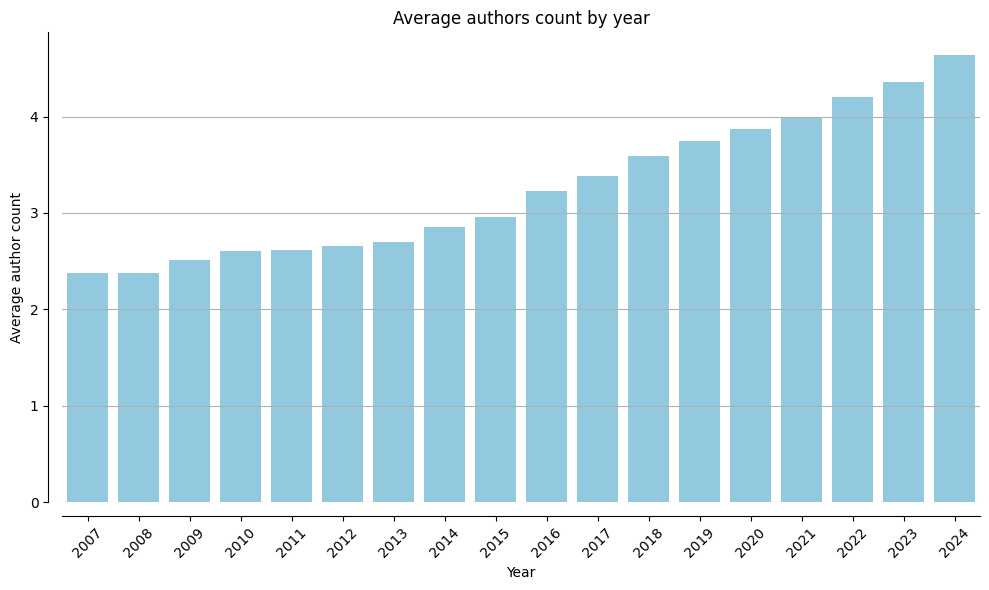

In [ ]:
cs_arxiv_df['update_date'] = pd.to_datetime(cs_arxiv_df['update_date'])

cs_arxiv_df['year'] = cs_arxiv_df['update_date'].dt.year
average_author_count_by_year = cs_arxiv_df.groupby('year')['num_authors'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='num_authors', data=average_author_count_by_year, color='skyblue',zorder=0)

sns.despine(offset=10, trim=False)
plt.title('Average authors count by year')
plt.xlabel('Year')
plt.ylabel('Average author count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

plt.show()

This bar plot shows the average number of authors colaborating for a research paper in Computer science field over the years

##**Topic Analysis (based on categories)**:



In official Arxiv website there is a separate page of called category taxonomy explaining the fullforms of the shortcuts mentioned and explanation which belonging to which category & sub category

In [ ]:
url = "https://arxiv.org/category_taxonomy"
response = requests.get(url)
page_source = response.text

soup = BeautifulSoup(page_source, 'html.parser')
category_list = soup.find(id='category_taxonomy_list')

categories = []
main_category = None
for category in category_list.find_all('h4'):
    if category.find_previous('h2'):
        main_category = category.find_previous('h2').text
    category_id = category.text.split(' (')[0]
    category_name = category.text.split('(')[1].split(')')[0]
    category_description = category.find_next('p').text
    categories.append({
        "ID": category_id,
        "Main Category": main_category,
        "Name": category_name,
        "Description": category_description
    })

categories_df = pd.DataFrame(categories)
categories_df

,ID,Main Category,Name,Description
0,cs.AI,Computer Science,Artificial Intelligence,"Covers all areas of AI except Vision, Robotics..."
1,cs.AR,Computer Science,Hardware Architecture,Covers systems organization and hardware archi...
2,cs.CC,Computer Science,Computational Complexity,"Covers models of computation, complexity class..."
3,cs.CE,Computer Science,"Computational Engineering, Finance, and Science",Covers applications of computer science to the...
4,cs.CG,Computer Science,Computational Geometry,Roughly includes material in ACM Subject Class...
...,...,...,...,...
150,stat.CO,Statistics,Computation,"Algorithms, Simulation, Visualization"
151,stat.ME,Statistics,Methodology,"Design, Surveys, Model Selection, Multiple Tes..."
152,stat.ML,Statistics,Machine Learning,"Covers machine learning papers (supervised, un..."
153,stat.OT,Statistics,Other Statistics,Work in statistics that does not fit into the ...


In [ ]:
cs_categories_df = categories_df[categories_df["Main Category"] == "Computer Science"]
cs_categories_df

,ID,Main Category,Name,Description
0,cs.AI,Computer Science,Artificial Intelligence,"Covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI. Roughly includes material in ACM Subject Classes I.2.0, I.2.1, I.2.3, I.2.4, I.2.8, and I.2.11."
1,cs.AR,Computer Science,Hardware Architecture,"Covers systems organization and hardware architecture. Roughly includes material in ACM Subject Classes C.0, C.1, and C.5."
2,cs.CC,Computer Science,Computational Complexity,"Covers models of computation, complexity classes, structural complexity, complexity tradeoffs, upper and lower bounds. Roughly includes material in ACM Subject Classes F.1 (computation by abstract devices), F.2.3 (tradeoffs among complexity measures), and F.4.3 (formal languages), although some material in formal languages may be more appropriate for Logic in Computer Science. Some material in F.2.1 and F.2.2, may also be appropriate here, but is more likely to have Data Structures and Algorithms as the primary subject area."
3,cs.CE,Computer Science,"Computational Engineering, Finance, and Science","Covers applications of computer science to the mathematical modeling of complex systems in the fields of science, engineering, and finance. Papers here are interdisciplinary and applications-oriented, focusing on techniques and tools that enable challenging computational simulations to be performed, for which the use of supercomputers or distributed computing platforms is often required. Includes material in ACM Subject Classes J.2, J.3, and J.4 (economics)."
4,cs.CG,Computer Science,Computational Geometry,Roughly includes material in ACM Subject Classes I.3.5 and F.2.2.
5,cs.CL,Computer Science,Computation and Language,"Covers natural language processing. Roughly includes material in ACM Subject Class I.2.7. Note that work on artificial languages (programming languages, logics, formal systems) that does not explicitly address natural-language issues broadly construed (natural-language processing, computational linguistics, speech, text retrieval, etc.) is not appropriate for this area."
6,cs.CR,Computer Science,Cryptography and Security,"Covers all areas of cryptography and security including authentication, public key cryptosytems, proof-carrying code, etc. Roughly includes material in ACM Subject Classes D.4.6 and E.3."
7,cs.CV,Computer Science,Computer Vision and Pattern Recognition,"Covers image processing, computer vision, pattern recognition, and scene understanding. Roughly includes material in ACM Subject Classes I.2.10, I.4, and I.5."
8,cs.CY,Computer Science,Computers and Society,"Covers impact of computers on society, computer ethics, information technology and public policy, legal aspects of computing, computers and education. Roughly includes material in ACM Subject Classes K.0, K.2, K.3, K.4, K.5, and K.7."
9,cs.DB,Computer Science,Databases,"Covers database management, datamining, and data processing. Roughly includes material in ACM Subject Classes E.2, E.5, H.0, H.2, and J.1."


In [ ]:
category_counts = categories_df['Main Category'].value_counts().reset_index()

category_counts.columns = ['Main Category', 'Count']
category_counts['Percentage'] = (category_counts['Count'] / category_counts['Count'].sum()) * 100

chart = alt.Chart(category_counts).mark_arc().encode(
    theta='Count:Q',
    color=alt.Color('Main Category:N', legend=alt.Legend(title='Main Category')),
    tooltip=['Main Category', 'Count', alt.Tooltip('Percentage:Q', format=".1f")],
).properties(
    title='Main Category Distribution',
    width=800,
    height=500
)

chart

alt.Chart(...)

The pie chart is representing the main category distribution and it is based on number of subcategorys that the each category contains

In [ ]:
# Top 20 Categories
loaded_data.map(lambda x: x['categories']).frequencies(sort = True).topk(20, key=1).compute()

[('astro-ph', 86911),
 ('hep-ph', 80984),
 ('quant-ph', 68512),
 ('hep-th', 58686),
 ('cs.CV', 57006),
 ('cond-mat.mtrl-sci', 39101),
 ('cond-mat.mes-hall', 34808),
 ('math.AP', 33857),
 ('gr-qc', 30396),
 ('astro-ph.GA', 30368),
 ('math.CO', 29331),
 ('astro-ph.SR', 26869),
 ('cond-mat.str-el', 26032),
 ('cs.CL', 23873),
 ('math.PR', 23548),
 ('astro-ph.HE', 22873),
 ('cs.IT math.IT', 22623),
 ('astro-ph.CO', 21818),
 ('math.NT', 21803),
 ('math.AG', 20124)]

In [ ]:
categories = lambda x: x['categories']

categories = (loaded_data
         .map(categories)
         .frequencies(sort = True))

(categories.topk(10, key=1)
      .compute())

[('astro-ph', 86911),
 ('hep-ph', 80984),
 ('quant-ph', 68512),
 ('hep-th', 58686),
 ('cs.CV', 57006),
 ('cond-mat.mtrl-sci', 39101),
 ('cond-mat.mes-hall', 34808),
 ('math.AP', 33857),
 ('gr-qc', 30396),
 ('astro-ph.GA', 30368)]

In [ ]:
categories = categories.to_dataframe(columns = ['categories','No.of submissions']).compute()
categories

,categories,No.of submissions
0,astro-ph,86911
1,hep-ph,80984
2,quant-ph,68512
3,hep-th,58686
4,cs.CV,57006
...,...,...
82916,supr-con cond-mat.supr-con hep-ex nucl-ex,1
82917,supr-con cond-mat.supr-con gr-qc hep-ph,1
82918,supr-con cond-mat.mtrl-sci cond-mat.supr-con,1
82919,supr-con cond-mat.mtrl-sci cond-mat.supr-con n...,1


In [ ]:
def add_comma(categories):
    return categories.replace(' ', ', ')
categories['categories'] = categories['categories'].apply(add_comma)

,categories,No.of submissions
82917,"supr-con, cond-mat.supr-con, gr-qc, hep-ph",1
82918,"supr-con, cond-mat.mtrl-sci, cond-mat.supr-con",1
82919,"supr-con, cond-mat.mtrl-sci, cond-mat.supr-con...",1
82920,"supr-con, cond-mat.supr-con, quant-ph",1


In [ ]:
def has_multiple_categories(row):
    return ',' in row['categories']

multiple_categories_df = categories [categories.apply(has_multiple_categories, axis=1)]
sum_of_submissions = multiple_categories_df['No.of submissions'].sum()
new_row = pd.DataFrame({
    'categories': ['multiple categories'],
    'No.of submissions': [sum_of_submissions]
})
categories = categories.drop(multiple_categories_df.index)
categories = pd.concat([categories, new_row], ignore_index=True)

categories

,categories,No.of submissions
0,astro-ph,86911
1,hep-ph,80984
2,quant-ph,68512
3,hep-th,58686
4,cs.CV,57006
...,...,...
145,nlin.CG,229
146,q-bio.SC,222
147,q-fin.EC,206
148,cs.GL,70


In [ ]:
# Merge the datasets on the common columns
merged_df = pd.merge(categories, categories_df, how='left', left_on='categories', right_on='ID')

              categories  No.of submissions        ID         Main Category  \
0               astro-ph              86911       NaN                   NaN   
1                 hep-ph              80984    hep-ph               Physics   
2               quant-ph              68512  quant-ph               Physics   
3                 hep-th              58686    hep-th               Physics   
4                  cs.CV              57006     cs.CV      Computer Science   
..                   ...                ...       ...                   ...   
145              nlin.CG                229   nlin.CG               Physics   
146             q-bio.SC                222  q-bio.SC  Quantitative Biology   
147             q-fin.EC                206  q-fin.EC  Quantitative Finance   
148                cs.GL                 70     cs.GL      Computer Science   
149  multiple categories            1147191       NaN                   NaN   

                                        Name  \
0  

In [ ]:
merged_df.drop(['ID','Description'], axis=1, inplace=True)

In [ ]:
merged_df

,categories,No.of submissions,Main Category,Name
0,astro-ph,86911,NaN,NaN
1,hep-ph,80984,Physics,High Energy Physics - Phenomenology
2,quant-ph,68512,Physics,Quantum Physics
3,hep-th,58686,Physics,High Energy Physics - Theory
4,cs.CV,57006,Computer Science,Computer Vision and Pattern Recognition
...,...,...,...,...
145,nlin.CG,229,Physics,Cellular Automata and Lattice Gases
146,q-bio.SC,222,Quantitative Biology,Subcellular Processes
147,q-fin.EC,206,Quantitative Finance,Economics
148,cs.GL,70,Computer Science,General Literature


In [ ]:
sorted_categories = merged_df.sort_values(by='No.of submissions', ascending=False)

# Select the top 10 categories
top_categories = sorted_categories.head(10)
top_categories

,categories,No.of submissions,Main Category,Name
149,multiple categories,1147191,NaN,NaN
0,astro-ph,86911,NaN,NaN
1,hep-ph,80984,Physics,High Energy Physics - Phenomenology
2,quant-ph,68512,Physics,Quantum Physics
3,hep-th,58686,Physics,High Energy Physics - Theory
4,cs.CV,57006,Computer Science,Computer Vision and Pattern Recognition
5,cond-mat.mtrl-sci,39101,Physics,Materials Science
6,cond-mat.mes-hall,34808,Physics,Mesoscale and Nanoscale Physics
7,math.AP,33857,Mathematics,Analysis of PDEs
8,gr-qc,30396,Physics,General Relativity and Quantum Cosmology


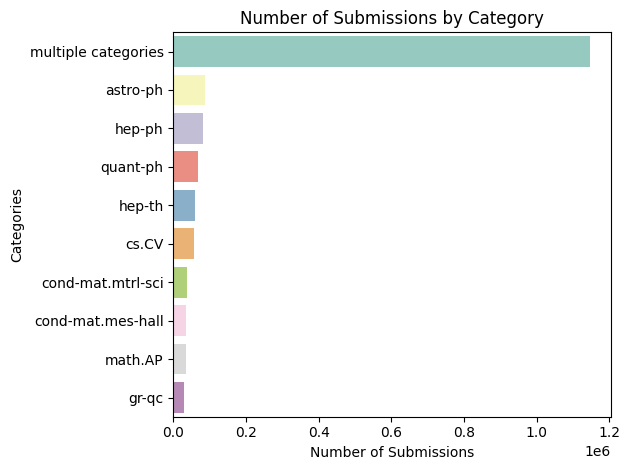

In [ ]:
sns.barplot(x="No.of submissions", y="categories", data=top_categories, hue="categories", palette="Set3",legend=False)  # Use a color palette
plt.xlabel("Number of Submissions")
plt.ylabel("Categories")
plt.title("Number of Submissions by Category")
plt.tight_layout()

plt.show()

The bar plots represents the number of papers belonging to each specific category to make it possible we made a special entry containing the total number of papers containg multiple categories and plot it in above showing the the difference between the gap

In [ ]:
data_after_2015.map(lambda x:x['categories']).frequencies(sort=True).topk(k=20,key=1).compute()

[('cs.CV', 55363),
 ('quant-ph', 33871),
 ('math.AP', 25183),
 ('astro-ph.GA', 23981),
 ('cond-mat.mtrl-sci', 23087),
 ('cs.CL', 23075),
 ('hep-ph', 21459),
 ('math.CO', 20600),
 ('cond-mat.mes-hall', 17876),
 ('hep-th', 15688),
 ('astro-ph.HE', 15645),
 ('cs.LG', 15512),
 ('math.PR', 14783),
 ('math.OC', 14740),
 ('math.NT', 14732),
 ('cs.IT math.IT', 14530),
 ('astro-ph.SR', 14326),
 ('cs.LG stat.ML', 13733),
 ('gr-qc', 12309),
 ('cond-mat.str-el', 11590)]

In [ ]:
data = [('cs.CV', 55363),
        ('quant-ph', 33871),
        ('math.AP', 25183),
        ('astro-ph.GA', 23981),
        ('cond-mat.mtrl-sci', 23087),
        ('cs.CL', 23075),
        ('hep-ph', 21459),
        ('math.CO', 20600),
        ('cond-mat.mes-hall', 17876),
        ('hep-th', 15688),
        ('astro-ph.HE', 15645),
        ('cs.LG', 15512),
        ('math.PR', 14783),
        ('math.OC', 14740),
        ('math.NT', 14732),
        ('cs.IT math.IT', 14530),
        ('astro-ph.SR', 14326),
        ('cs.LG stat.ML', 13733),
        ('gr-qc', 12309),
        ('cond-mat.str-el', 11590)]

df = pd.DataFrame(data, columns=['Name', 'Count'])
df['Percentage'] = (df['Count'] / df['Count'].sum()) * 100

chart = alt.Chart(df).mark_bar().encode(
    y=alt.Y('Name:N', title='Category'),
    x=alt.X('Count:Q', title='Number of Papers', axis=dict(format=',.0f')),
    color=alt.Color('Name:N', legend=alt.Legend(title='Sub Category')),
    tooltip=[alt.Tooltip('Name', title='Sub Category'), 'Count', alt.Tooltip('Percentage:Q', title='Percentage', format=".1f")]
).properties(
    title='Distribution of Papers by Sub Category',
    width=800,
    height=500
)

chart


alt.Chart(...)

The above bar plot represent the distribution of various papers across many categories from 2015 (Here we have taken multiple categories into consideration by counting it into is categories)

In [ ]:
merged_df = pd.merge(df, cs_categories_df, left_on='categories', right_on='ID', how='left')

category_counts = merged_df['Name'].value_counts().reset_index()
category_counts.columns = ['Name', 'Count']

category_counts['Percentage'] = (category_counts['Count'] / category_counts['Count'].sum()) * 100

chart = alt.Chart(category_counts).mark_bar().encode(
    y=alt.Y('Name:N', title='Category'),
    x=alt.X('Count:Q', title='Number of Papers'),
    color=alt.Color('Name:N', legend=alt.Legend(title='Sub Category')),
    tooltip=['Name', 'Count', alt.Tooltip('Percentage:Q', format=".1f")]
).properties(
    title='Distribution of Papers by Sub Categories in CS',
    width=800,
    height=500
)

chart

alt.Chart(...)

Above bar plot represents the number of papers published in each sub category of Computer Science Field

In [ ]:
# Create an empty graph
G = nx.Graph()

# Iterate through each publication
for categories in cs_arxiv_df['categories']:
    # Extract individual categories from the publication
    categories_list = categories.split(' ')

    # Add edges between categories in the graph
    for i in range(len(categories_list)):
        for j in range(i+1, len(categories_list)):
            category1 = categories_list[i]
            category2 = categories_list[j]
            G.add_edge(category1, category2)

# Calculate betweenness centrality for each node
node_betweenness = nx.betweenness_centrality(G)

# Create positions for the nodes using a spring layout algorithm with a higher k value for a more sparse layout
pos = nx.spring_layout(G, k=2)

# Create edge trace
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create node trace
node_x = []
node_y = []
node_text = []
node_size = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)
    node_size.append(node_betweenness[node])

# Define the scaling factor and adjust the size range
scaling_factor = 10000
min_size = 5
max_size = 50

# Scale the node sizes based on the betweenness centrality
scaled_node_size = [min_size + (s * scaling_factor) for s in node_size]
scaled_node_size = [min(s, max_size) for s in scaled_node_size]

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Create node trace
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    text=node_text,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color='#54a34a',
        size=scaled_node_size,
        line=dict(width=2)
    )
)

fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title='Interconnections between Categories',
        titlefont=dict(size=16),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

fig.show()

This graph shows the interconnection between categories where the nodes represents the sub categories and the edges represents the connection between two of the categories. The more number of categories, the distance between them is low and and more number of interconnections, makes the node look bigger

In [ ]:
response = requests.get("https://arxiv.org/category_taxonomy")
if response.status_code == 200:

    soup = BeautifulSoup(response.content, 'html.parser')
    taxonomy_div = soup.find('div', id='category_taxonomy_list')
    category_dict = {}

    father_categories_h2 = taxonomy_div.find_all('h2', class_='accordion-head')
    father_categories_h3 = taxonomy_div.find_all('h3', class_='column is-one-fifth')
    father_categories = father_categories_h2 + father_categories_h3
    for father_category in father_categories:
        father_category_name = father_category.text.strip()
        sub_categories = father_category.find_next_sibling().find_all('h4')
        for sub_category in sub_categories:

            sub_category_name = sub_category.text.strip()
            sub_category_code = sub_category_name.split()[0]
            category_dict[sub_category_code] = father_category_name

    print(category_dict)
else:
    print("Failed to retrieve webpage content. Status code:", response.status_code)

{'cs.AI': 'Computer Science', 'cs.AR': 'Computer Science', 'cs.CC': 'Computer Science', 'cs.CE': 'Computer Science', 'cs.CG': 'Computer Science', 'cs.CL': 'Computer Science', 'cs.CR': 'Computer Science', 'cs.CV': 'Computer Science', 'cs.CY': 'Computer Science', 'cs.DB': 'Computer Science', 'cs.DC': 'Computer Science', 'cs.DL': 'Computer Science', 'cs.DM': 'Computer Science', 'cs.DS': 'Computer Science', 'cs.ET': 'Computer Science', 'cs.FL': 'Computer Science', 'cs.GL': 'Computer Science', 'cs.GR': 'Computer Science', 'cs.GT': 'Computer Science', 'cs.HC': 'Computer Science', 'cs.IR': 'Computer Science', 'cs.IT': 'Computer Science', 'cs.LG': 'Computer Science', 'cs.LO': 'Computer Science', 'cs.MA': 'Computer Science', 'cs.MM': 'Computer Science', 'cs.MS': 'Computer Science', 'cs.NA': 'Computer Science', 'cs.NE': 'Computer Science', 'cs.NI': 'Computer Science', 'cs.OH': 'Computer Science', 'cs.OS': 'Computer Science', 'cs.PF': 'Computer Science', 'cs.PL': 'Computer Science', 'cs.RO': 'Com

In [ ]:
url = "https://arxiv.org/category_taxonomy"

response = requests.get(url)

if response.status_code == 200:

    soup = BeautifulSoup(response.text, 'html.parser')

    category_elements = soup.find_all(['h3','h4'])
    categories_dict = {}

    for category_element in category_elements:
        category_key = category_element.text.strip().split()[0]
        span_element = category_element.find('span')
        if span_element:
            category_value = span_element.text.strip()
        else:
            category_value = "No Value Found"

        if (category_value!="No Value Found"):
            categories_dict[category_key] = category_value.strip(')').strip('(')
    for key, value in categories_dict.items():
        print(f"Key: {key}")
        print(f"Value: {value}")
        print()

else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

Key: cs.AI
Value: Artificial Intelligence

Key: cs.AR
Value: Hardware Architecture

Key: cs.CC
Value: Computational Complexity

Key: cs.CE
Value: Computational Engineering, Finance, and Science

Key: cs.CG
Value: Computational Geometry

Key: cs.CL
Value: Computation and Language

Key: cs.CR
Value: Cryptography and Security

Key: cs.CV
Value: Computer Vision and Pattern Recognition

Key: cs.CY
Value: Computers and Society

Key: cs.DB
Value: Databases

Key: cs.DC
Value: Distributed, Parallel, and Cluster Computing

Key: cs.DL
Value: Digital Libraries

Key: cs.DM
Value: Discrete Mathematics

Key: cs.DS
Value: Data Structures and Algorithms

Key: cs.ET
Value: Emerging Technologies

Key: cs.FL
Value: Formal Languages and Automata Theory

Key: cs.GL
Value: General Literature

Key: cs.GR
Value: Graphics

Key: cs.GT
Value: Computer Science and Game Theory

Key: cs.HC
Value: Human-Computer Interaction

Key: cs.IR
Value: Information Retrieval

Key: cs.IT
Value: Information Theory

Key: cs.LG
Val

In [ ]:
cs_arxiv_df['sep_categories'] = cs_arxiv_df['categories'].str.split()
cs_arxiv_df= cs_arxiv_df[cs_arxiv_df['year']<2024]

df_exploded = cs_arxiv_df.explode('sep_categories')
df_exploded['category'] = df_exploded['sep_categories'].str.strip().map(categories_dict)
print(len(df_exploded))

df_exploded.dropna(inplace=True)
df_exploded

1143099


,id,authors,title,categories,abstract,versions,update_date,authors_parsed,num_authors,year,num_versions,sep_categories,category
0,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use\nit obtain a characterization of the family of $(k,\ell)$-sparse graphs and\nalgorithmic solutions to a family of problems concerning tree decompositions of\ngraphs. Special instances of sparse graphs appear in rigidity theory and have\nreceived increased attention in recent years. In particular, our colored\npebbles generalize and strengthen the previous results of Lee and Streinu and\ngive a new proof of the Tutte-Nash-Williams characterization of arboricity. We\nalso present a new decomposition that certifies sparsity based on the\n$(k,\ell)$-pebble game with colors. Our work also exposes connections between\npebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and\nWestermann and Hendrickson.\n","[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 02:26:18 GMT'}, {'version': 'v2', 'created': 'Sat, 13 Dec 2008 17:26:00 GMT'}]",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2,2008,2,math.CO,Combinatorics
0,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use\nit obtain a characterization of the family of $(k,\ell)$-sparse graphs and\nalgorithmic solutions to a family of problems concerning tree decompositions of\ngraphs. Special instances of sparse graphs appear in rigidity theory and have\nreceived increased attention in recent years. In particular, our colored\npebbles generalize and strengthen the previous results of Lee and Streinu and\ngive a new proof of the Tutte-Nash-Williams characterization of arboricity. We\nalso present a new decomposition that certifies sparsity based on the\n$(k,\ell)$-pebble game with colors. Our work also exposes connections between\npebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and\nWestermann and Hendrickson.\n","[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 02:26:18 GMT'}, {'version': 'v2', 'created': 'Sat, 13 Dec 2008 17:26:00 GMT'}]",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2,2008,2,cs.CG,Computational Geometry
1,0704.0046,"I. Csiszar, F. Hiai and D. Petz",A limit relation for entropy and channel capacity per unit cost,quant-ph cs.IT math.IT,"In a quantum mechanical model, Diosi, Feldmann and Kosloff arrived at a\nconjecture stating that the limit of the entropy of certain mixtures is the\nrelative entropy as system size goes to infinity. The conjecture is proven in\nthis paper for density matrices. The first proof is analytic and uses the\nquantum law of large numbers. The second one clarifies the relation to channel\ncapacity per unit cost for classical-quantum channels. Both proofs lead to\ngeneralization of the conjecture.\n","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 16:37:36 GMT'}]",2009-11-13,"[[Csiszar, I., ], [Hiai, F., ], [Petz, D., ]]",3,2009,1,quant-ph,Quantum Physics
1,0704.0046,"I. Csiszar, F. Hiai and D. Petz",A limit relation for entropy and channel capacity per unit cost,quant-ph cs.IT math.IT,"In a quantum mechanical model, Diosi, Feldmann and Kosloff arrived at a\nconjecture stating that the limit of the entropy of certain mixtures is the\nrelative entropy as system size goes to infinity. The conjecture is proven in\nthis paper for density matrices. The first proof is analytic and uses the\nquantum law of large numbers. The second one clarifies the relation to channel\ncapacity per unit cost for classical-quantum channels. Both proofs lead to\ngeneralization of the conjecture.\n","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 16:37:36 GMT'}]",2009-11-13,"[[Csiszar, I., ], [Hiai, F., ], [Petz, D., ]]",3,2009,1,cs.IT,Information Theory
1,0704.0046,"I. Csiszar, F. Hiai and D. P

In [ ]:
# Calculate the number of topics for each publication
cs_arxiv_df['count_topics'] = cs_arxiv_df['categories'].apply(lambda x: len(x.split()))
cs_arxiv_df

<ipython-input-70-c66bd872879f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,authors,title,categories,abstract,versions,update_date,authors_parsed,num_authors,year,num_versions,sep_categories,count_topics
0,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use\nit obtain a characterization of the family of $(k,\ell)$-sparse graphs and\nalgorithmic solutions to a family of problems concerning tree decompositions of\ngraphs. Special instances of sparse graphs appear in rigidity theory and have\nreceived increased attention in recent years. In particular, our colored\npebbles generalize and strengthen the previous results of Lee and Streinu and\ngive a new proof of the Tutte-Nash-Williams characterization of arboricity. We\nalso present a new decomposition that certifies sparsity based on the\n$(k,\ell)$-pebble game with colors. Our work also exposes connections between\npebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and\nWestermann and Hendrickson.\n","[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 02:26:18 GMT'}, {'version': 'v2', 'created': 'Sat, 13 Dec 2008 17:26:00 GMT'}]",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2,2008,2,"[math.CO, cs.CG]",2
1,0704.0046,"I. Csiszar, F. Hiai and D. Petz",A limit relation for entropy and channel capacity per unit cost,quant-ph cs.IT math.IT,"In a quantum mechanical model, Diosi, Feldmann and Kosloff arrived at a\nconjecture stating that the limit of the entropy of certain mixtures is the\nrelative entropy as system size goes to infinity. The conjecture is proven in\nthis paper for density matrices. The first proof is analytic and uses the\nquantum law of large numbers. The second one clarifies the relation to channel\ncapacity per unit cost for classical-quantum channels. Both proofs lead to\ngeneralization of the conjecture.\n","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 16:37:36 GMT'}]",2009-11-13,"[[Csiszar, I., ], [Hiai, F., ], [Petz, D., ]]",3,2009,1,"[quant-ph, cs.IT, math.IT]",3
2,0704.0047,T. Kosel and I. Grabec,Intelligent location of simultaneously active acoustic emission sources:\n Part I,cs.NE cs.AI,"The intelligent acoustic emission locator is described in Part I, while Part\nII discusses blind source separation, time delay estimation and location of two\nsimultaneously active continuous acoustic emission sources.\n The location of acoustic emission on complicated aircraft frame structures is\na difficult problem of non-destructive testing. This article describes an\nintelligent acoustic emission source locator. The intelligent locator comprises\na sensor antenna and a general regression neural network, which solves the\nlocation problem based on learning from examples. Locator performance was\ntested on different test specimens. Tests have shown that the accuracy of\nlocation depends on sound velocity and attenuation in the specimen, the\ndimensions of the tested area, and the properties of stored data. The location\naccuracy achieved by the intelligent locator is comparable to that obtained by\nthe conventional triangulation method, while the applicability of the\nintelligent locator is more general since analysis of sonic ray paths is\navoided. This is a promising method for non-destructive testing of aircraft\nframe structures by the acoustic emission method.\n","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 13:06:50 GMT'}]",2009-09-29,"[[Kosel, T., ], [Grabec, I., ]]",2,2009,1,"[cs.NE, cs.AI]",2
3,0704.0050,T. Kosel and I. Grabec,Intelligent location of simultaneously active acoustic emission sources:\n Part II,cs.NE cs.AI,"Part I describes an intelligent acoustic emission locator, while Part II\ndiscusses blind source separation, time delay estimation and location of two\ncontinuous acoustic emission sources.\n Acoustic emission (AE) analysis is used for characterization and location of\ndeveloping defects in materials. AE sources often generate a mixture of various\nstatistical

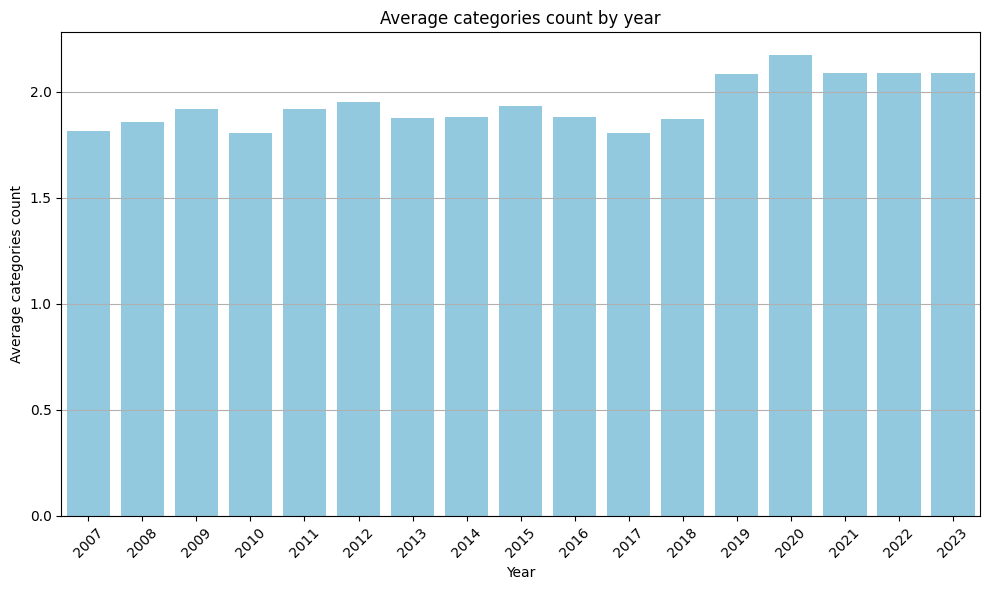

In [ ]:
average_topic_count_by_year = cs_arxiv_df.groupby('year')['count_topics'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='count_topics', data=average_topic_count_by_year, color='skyblue',zorder=0)
plt.title('Average categories count by year')
plt.xlabel('Year')
plt.ylabel('Average categories count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The above bar plot represents the average number of collaborations between categories happeing for a research paper in computer science field

In [ ]:
df_exploded['top_category'] = df_exploded['sep_categories'].apply(lambda x: category_dict[x])
df_exploded

,id,authors,title,categories,abstract,versions,update_date,authors_parsed,num_authors,year,num_versions,sep_categories,category,top_category
0,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use\nit obtain a characterization of the family of $(k,\ell)$-sparse graphs and\nalgorithmic solutions to a family of problems concerning tree decompositions of\ngraphs. Special instances of sparse graphs appear in rigidity theory and have\nreceived increased attention in recent years. In particular, our colored\npebbles generalize and strengthen the previous results of Lee and Streinu and\ngive a new proof of the Tutte-Nash-Williams characterization of arboricity. We\nalso present a new decomposition that certifies sparsity based on the\n$(k,\ell)$-pebble game with colors. Our work also exposes connections between\npebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and\nWestermann and Hendrickson.\n","[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 02:26:18 GMT'}, {'version': 'v2', 'created': 'Sat, 13 Dec 2008 17:26:00 GMT'}]",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2,2008,2,math.CO,Combinatorics,Mathematics
0,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use\nit obtain a characterization of the family of $(k,\ell)$-sparse graphs and\nalgorithmic solutions to a family of problems concerning tree decompositions of\ngraphs. Special instances of sparse graphs appear in rigidity theory and have\nreceived increased attention in recent years. In particular, our colored\npebbles generalize and strengthen the previous results of Lee and Streinu and\ngive a new proof of the Tutte-Nash-Williams characterization of arboricity. We\nalso present a new decomposition that certifies sparsity based on the\n$(k,\ell)$-pebble game with colors. Our work also exposes connections between\npebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and\nWestermann and Hendrickson.\n","[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 02:26:18 GMT'}, {'version': 'v2', 'created': 'Sat, 13 Dec 2008 17:26:00 GMT'}]",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2,2008,2,cs.CG,Computational Geometry,Computer Science
1,0704.0046,"I. Csiszar, F. Hiai and D. Petz",A limit relation for entropy and channel capacity per unit cost,quant-ph cs.IT math.IT,"In a quantum mechanical model, Diosi, Feldmann and Kosloff arrived at a\nconjecture stating that the limit of the entropy of certain mixtures is the\nrelative entropy as system size goes to infinity. The conjecture is proven in\nthis paper for density matrices. The first proof is analytic and uses the\nquantum law of large numbers. The second one clarifies the relation to channel\ncapacity per unit cost for classical-quantum channels. Both proofs lead to\ngeneralization of the conjecture.\n","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 16:37:36 GMT'}]",2009-11-13,"[[Csiszar, I., ], [Hiai, F., ], [Petz, D., ]]",3,2009,1,quant-ph,Quantum Physics,Physics
1,0704.0046,"I. Csiszar, F. Hiai and D. Petz",A limit relation for entropy and channel capacity per unit cost,quant-ph cs.IT math.IT,"In a quantum mechanical model, Diosi, Feldmann and Kosloff arrived at a\nconjecture stating that the limit of the entropy of certain mixtures is the\nrelative entropy as system size goes to infinity. The conjecture is proven in\nthis paper for density matrices. The first proof is analytic and uses the\nquantum law of large numbers. The second one clarifies the relation to channel\ncapacity per unit cost for classical-quantum channels. Both proofs lead to\ngeneralization of the conjecture.\n","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 16:37:36 GMT'}]",2009-11-13,"[[Csiszar, I., ], [Hiai, F., ], [Petz, D., ]]",3,2009,1,cs.IT,Informatio

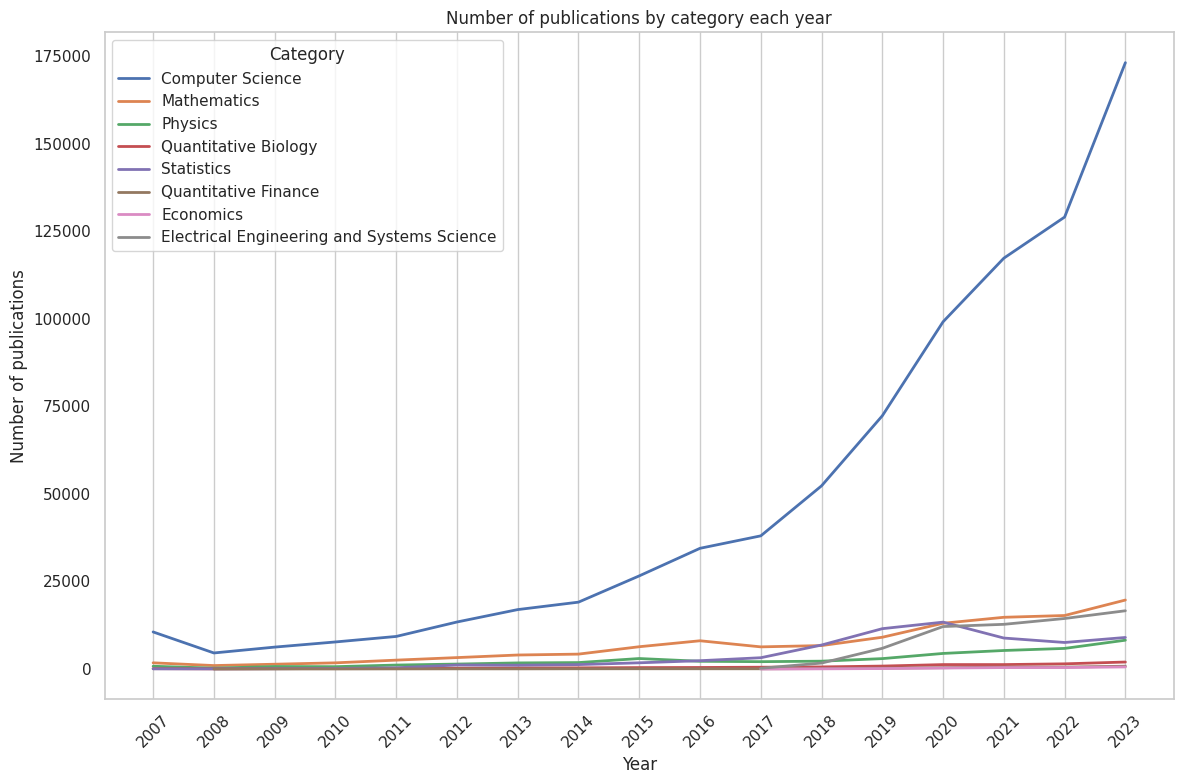

In [ ]:
publications_by_category_year = df_exploded.groupby(['year', 'top_category']).size().reset_index(name='count')
publications_by_category_year['year'] = publications_by_category_year['year'].astype(str)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.lineplot(x='year', y='count', hue='top_category', data=publications_by_category_year,markers=True, dashes=False,lw=2)
plt.title('Number of publications by category each year')
plt.xlabel('Year')
plt.ylabel('Number of publications')
plt.legend(title='Category', loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('Number_of_Publications_by_Category_by_Year.png')
plt.show()

The line plot shows the various number of categories collaborating with Computer Science in research papers across the years.

The blue line indicatices the total number of computer science field papers and remaining lines shows the growth in numbers.

## **Word Analysis On Titles**

During the Topic analysis we got to know the top  categories having high number of publications in recent years so below we tried to plot some bar graphs showing the top words with more number of repitations in titles in top 5 categories

In [ ]:
def get_metadata():
    with open('/content/arxiv-metadata-oai-snapshot.json', 'r') as f:
        for line in f:
            yield line

In [ ]:
metadata = get_metadata()

In [ ]:
titles_tags_dict = {"title":[], "tags":[]}
for paper in metadata:
    parsed = json.loads(paper)
    titles_tags_dict["title"].append(parsed['title'])
    titles_tags_dict["tags"].append(parsed['categories'])

In [ ]:
# ('astro-ph', 86911),
#  ('hep-ph', 80984),
#  ('quant-ph', 68512),
#  ('hep-th', 58686),
#  ('cs.CV', 57006),

In [ ]:
titles_tags_df = pd.DataFrame.from_dict(titles_tags_dict)

In [ ]:
subset_categories = {'astro-ph.EP': 'Earth and Planetary Astrophysics',
'hep-ph': 'High Energy Physics - Phenomenology',
'quant-ph': 'Quantum Physics',
'hep-th': 'High Energy Physics - Theory',
'cs.CV':'Computer Vision and Pattern Recognition'}


In [ ]:
astro_ph_df = titles_tags_df[titles_tags_df["tags"] == "astro-ph.EP"]
hep_ph_df = titles_tags_df[titles_tags_df["tags"] == "hep-ph"]
quant_ph_df = titles_tags_df[titles_tags_df["tags"] == "quant-ph"]
hep_th_df = titles_tags_df[titles_tags_df["tags"] == "hep-th"]
cs_cv_df = titles_tags_df[titles_tags_df["tags"] == "cs.CV"]

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We are using stop words so that words like of, is, and won't be shown as we know they are commonly used .

In [ ]:
stop_words = set(stopwords.words('english'))
def get_wc_df(df):
    data = df.copy(deep=True)
    vectorizer = CountVectorizer()
    wc_mat = vectorizer.fit_transform(list(data['title']))
    feature_names = vectorizer.get_feature_names_out()
    return pd.DataFrame({"word": feature_names, "count": list(np.sum(wc_mat.toarray(), axis=0))}).sort_values(by="count", ascending=False).reset_index(drop=True)


In [ ]:
top_astro = get_wc_df(astro_ph_df)[:20]
top_hep_ph = get_wc_df(hep_ph_df)[:20]
top_quant = get_wc_df(quant_ph_df)[:20]
top_hep_th = get_wc_df(hep_th_df)[:20]
top_cs_cv = get_wc_df(cs_cv_df)[:20]

In [ ]:
top_astro = top_astro[~top_astro['word'].isin(stop_words)]
px.bar(data_frame=top_astro, x = "word", y = "count", title="Most Common Title Words: Earth and Planetary Astrophysics", color='count')

In [ ]:
top_hep_ph = top_hep_ph[~top_hep_ph['word'].isin(stop_words)]
px.bar(data_frame=top_hep_ph, x = "word", y = "count", title="Most Common Title Words:High Energy Physics - Phenomenology", color='count')

In [ ]:
top_quant = top_quant[~top_quant['word'].isin(stop_words)]
px.bar(data_frame=top_quant, x = "word", y = "count", title="Most Common Title Words:Quantum Physics", color='count')

In [ ]:
top_hep_th = top_hep_th[~top_hep_th['word'].isin(stop_words)]
px.bar(data_frame=top_hep_th, x = "word", y = "count", title="Most Common Title Words:High Energy Physics - Theory", color='count')

In [ ]:
top_cs_cv = top_cs_cv[~top_cs_cv['word'].isin(stop_words)]
px.bar(data_frame=top_cs_cv, x = "word", y = "count", title="Most Common Title Words:Computer Vision and Pattern Recognition", color='count')